In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#individual layers from keras
from tensorflow.keras.layers import Conv1D, LeakyReLU, GaussianNoise, Add
from tensorflow.keras import ops

print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<b> Network architecture from Tarabanis et al. https://doi.org/10.1016/j.jacep.2022.09.021</b>


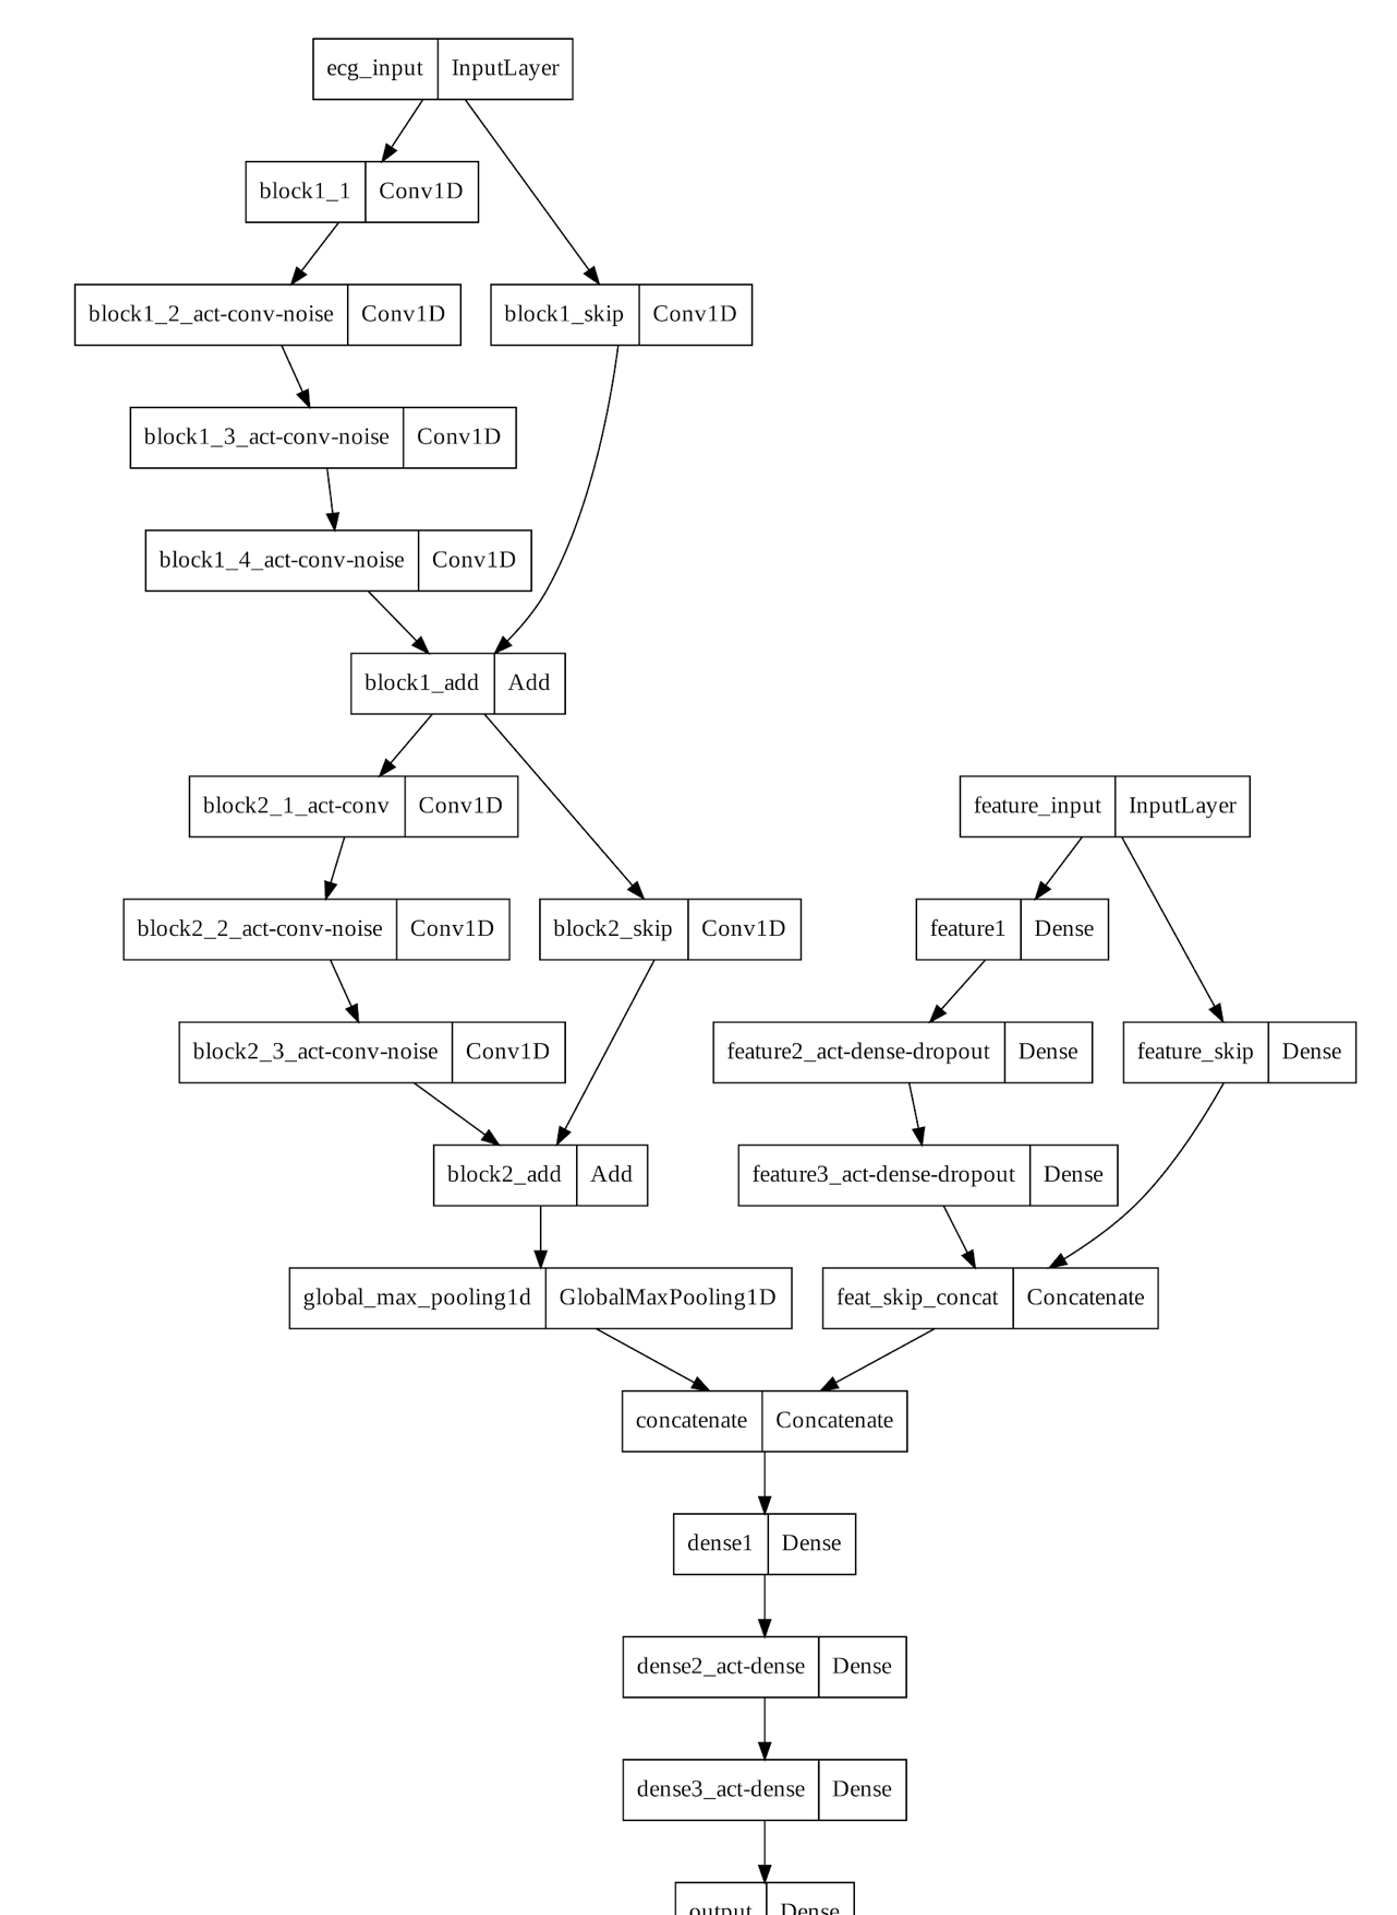



In [ ]:
# Define the block layers of CNN - use functional API to implement residuals

#input layer (1250 time samples x 12 ECG channels)
time_samples = 1250
channels = 12

#Input to L-side of model (ecg channels)
ecg_inputs = keras.Input(shape=(time_samples, channels))

#convolution_params
conv_kernel_size = 56
conv_filter_size = 128
conv_dilation_rate = 3

#noise params
gauss_noise_stdev = 0.0013

#Block 1_1 - 1D convolution
b1_1_conv1D = Conv1D(
    filters=conv_filter_size, 
    kernel_size=conv_kernel_size,
    dilation_rate=conv_dilation_rate,
    padding='same')(ecg_inputs)

#Block_1_skip - 1D conv (residual)
b1_skip_conv1D = Conv1D(
    filters=conv_filter_size, 
    kernel_size=conv_kernel_size,
    dilation_rate=conv_dilation_rate,
    padding='same')(ecg_inputs)

#will need to modify function below to autofill hyperparameters later in development
#act-conv_noise generic reusuable block
def act_conv_noise(inputs, block_name='ActConvNoise'):
    #include in network flow graph
    with tf.name_scope(block_name):
        #activation params
        leaky_relu_alpha = 0.20631

        #convolution_params
        conv_kernel_size = 56
        conv_filter_size = 128
        conv_dilation_rate = 3
        gauss_noise_stdev = 0.0013

        #activation
        act = LeakyReLU(negative_slope=leaky_relu_alpha)(inputs)

        #convolution
        conv = Conv1D(filters=conv_filter_size, 
                    kernel_size=conv_kernel_size,
                    dilation_rate=conv_dilation_rate,
                    padding='same')(act)
        
        #noise
        output_layer = GaussianNoise(stddev=gauss_noise_stdev)(conv)
        return output_layer
    

def act_conv(inputs, block_name='ActConvNoise'):
    #include in network flow graph
    with tf.name_scope(block_name):
        #activation params
        leaky_relu_alpha = 0.20631

        #convolution_params
        conv_kernel_size = 56
        conv_filter_size = 128
        conv_dilation_rate = 3

        #activation
        act = LeakyReLU(negative_slope=leaky_relu_alpha)(inputs)

        #convolution
        output_layer = Conv1D(filters=conv_filter_size, 
                    kernel_size=conv_kernel_size,
                    dilation_rate=conv_dilation_rate,
                    padding='same')(act)
        return output_layer    

In [32]:
#Arrange the layers into unified network

#block 1_1
b1_1_conv1D
#block 1_2
b1_2_act_conv_noise = act_conv_noise(b1_1_conv1D, 'block1_2')
#block 1_3
b1_3_act_conv_noise = act_conv_noise(b1_2_act_conv_noise, 'block1_3')
#block 1_4
b1_4_act_conv_noise = act_conv_noise(b1_3_act_conv_noise, 'block1_4')

#block1_skip identity after 1D conv
b1_skip_conv1D

#Add transformation and identity
b1_add = Add()([b1_4_act_conv_noise, b1_skip_conv1D])


Model: "ecg_QTC_buprop_level_predict"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1250, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 1250, 128) │     86,144 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_19      │ (None, 1250, 128) │          0 │ conv1d_28[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 1250, 128) │    917,632 │ leaky_re_lu_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_18   │ (None, 1250, 128) │          0 │ conv1d_33[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_20      │ (None, 1250, 128) │          0 │ gaussian_noise_1… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 1250, 128) │    917,632 │ leaky_re_lu_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_19   │ (None, 1250, 128) │          0 │ conv1d_34[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_21      │ (None, 1250, 128) │          0 │ gaussian_noise_1… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 1250, 128) │    917,632 │ leaky_re_lu_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_20   │ (None, 1250, 128) │          0 │ conv1d_35[0][0]   │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 1250, 128) │     86,144 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1250, 128) │          0 │ gaussian_noise_2… │
│                     │                   │            │ conv1d_29[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,925,184 (11.16 MB)

 Trainable params: 2,925,184 (11.16 MB)

 Non-trainable params: 0 (0.00 B)

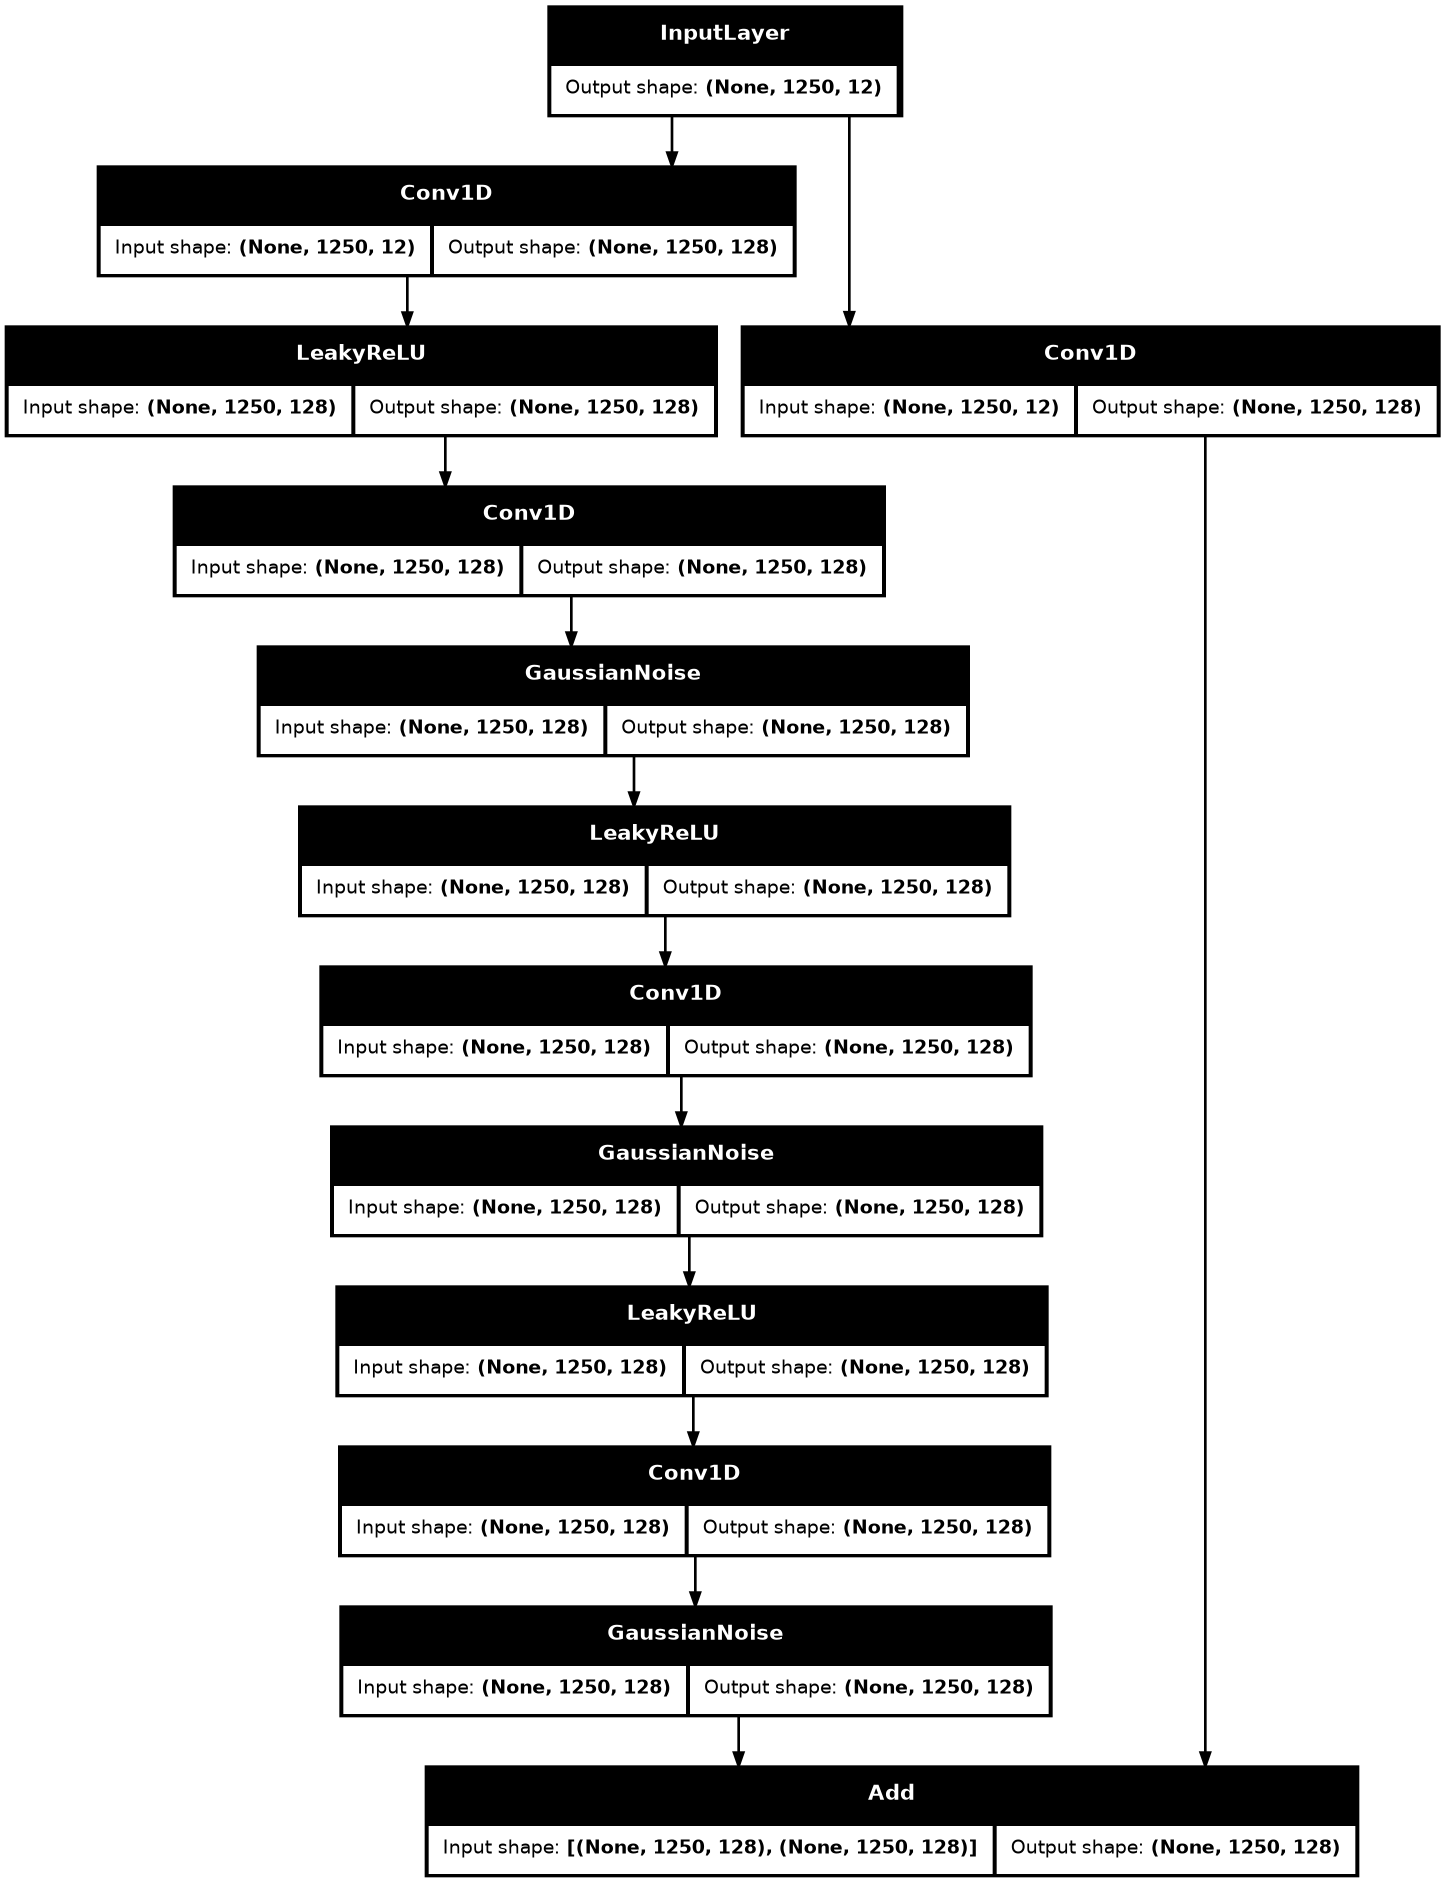

In [34]:
#Define the model and plot the model tree
model = keras.Model(inputs=ecg_inputs, outputs=b1_add, name="ecg_QTC_buprop_level_predict")

model.summary()
keras.utils.plot_model(model, "ecg_QTC_buprop_level_predi.png", show_shapes=True, dpi=96)